## 1. Carga de librerias, modelos y herramientas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utilsforecast.preprocessing import fill_gaps
from sklearn.preprocessing import MinMaxScaler
from pickle import dump

In [2]:
def pretreat_data_df(df, col_name):
    new_df = df[df['interaction'] == col_name].copy()
    new_df.rename(columns={'data.value': col_name}, inplace=True)
    new_df.drop(columns='interaction', inplace=True)
    new_df.set_index('timestamp', inplace=True)
    new_df[col_name] = new_df[col_name].astype(float)
    return new_df

def pretreat_true_false_data_df(df, col_name):
    new_df = df[df['interaction'] == col_name].copy()
    new_df.rename(columns={'data.value': col_name}, inplace=True)
    new_df.drop(columns='interaction', inplace=True)
    new_df.set_index('timestamp', inplace=True)
    new_df[col_name] = new_df[col_name].apply(lambda x: 1 if x == 'true' else 0)
    return new_df

Para este primer acercamiento se tomará como referencia los datos del sensor Suntracer localizado en el Edificio Centro de Investigaciones Tecnológicas de la Información y las Comunicaciones.

In [4]:
# Load the data
data = pd.read_csv('../data/wot-data-db.interactions-datas_suntracer.csv')
data['timestamp'] = pd.to_datetime(data['timestamp']).dt.round("min").dt.tz_localize(None)
df_test = data[['timestamp', 'data.value', 'interaction']]

df_temperature = pretreat_data_df(df_test, 'temperature')
df_brightness = pretreat_data_df(df_test, 'brightness')
df_wind = pretreat_data_df(df_test, 'wind')
df_rain = pretreat_true_false_data_df(df_test, 'rain')

df_rain

,rain
timestamp,
2023-03-05 19:15:00,1
2023-03-05 19:29:00,0
2023-03-05 19:37:00,1
2023-03-05 20:11:00,0
2023-03-06 20:22:00,1
...,...
2024-07-11 07:06:00,0
2024-07-11 07:10:00,1
2024-07-11 07:26:00,0


In [5]:
def plot_data(df, col_name):
    plt.figure(figsize=(10,6))
    plt.plot(df)
    plt.title('Suntracer ' + col_name)
    plt.ylabel(col_name)
    plt.show()

def plot_hist(df, col_name):
    plt.figure(figsize=(10,6))
    plt.hist(df)
    plt.title('Suntracer ' + col_name)
    plt.ylabel('Frequency')
    plt.show()

def plot_day_data(df, col_name):
    plt.figure(figsize=(10,6))
    plt.plot(df[col_name].loc['2020-03-05':'2020-03-06'])
    plt.title('1 day Suntracer ' + col_name)
    plt.ylabel(col_name)
    plt.show()

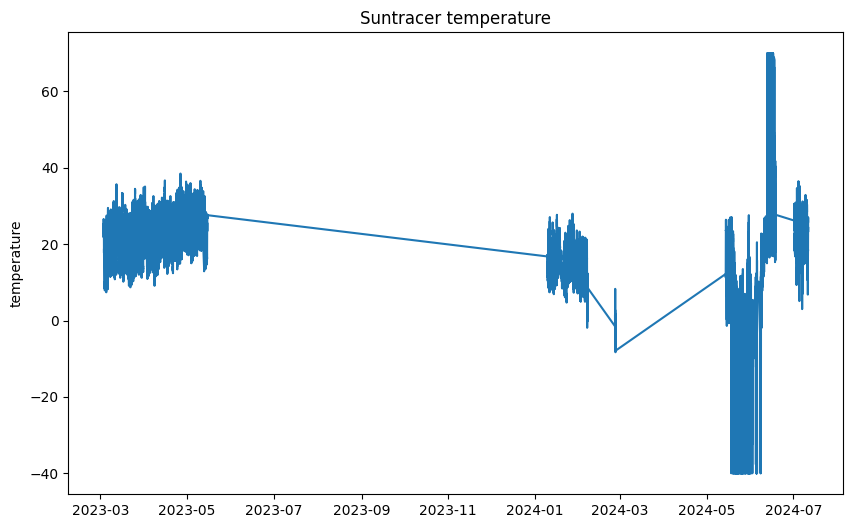

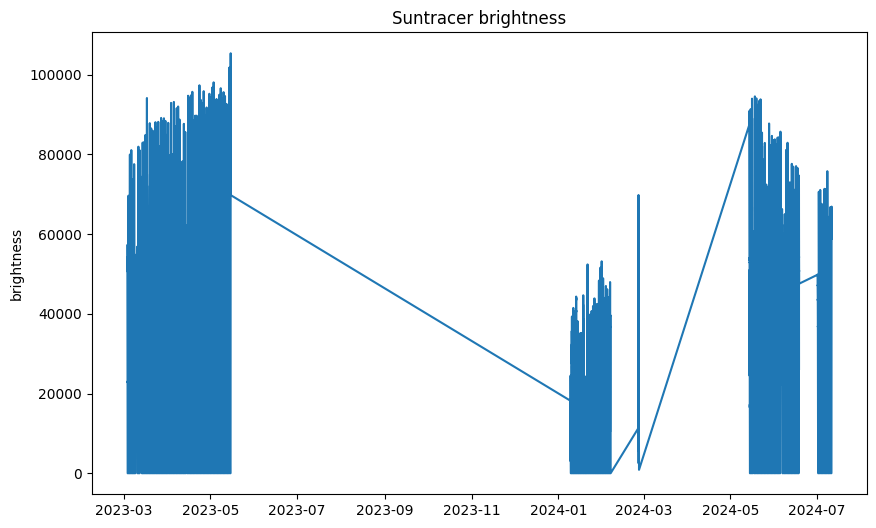

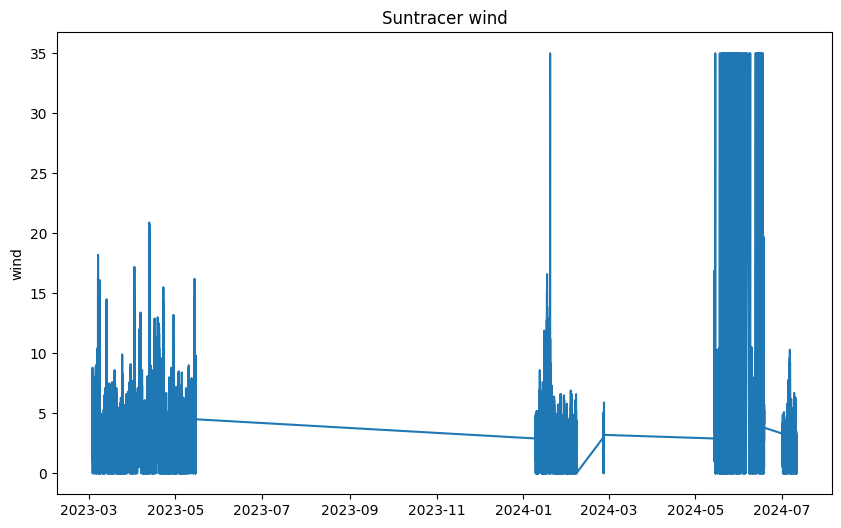

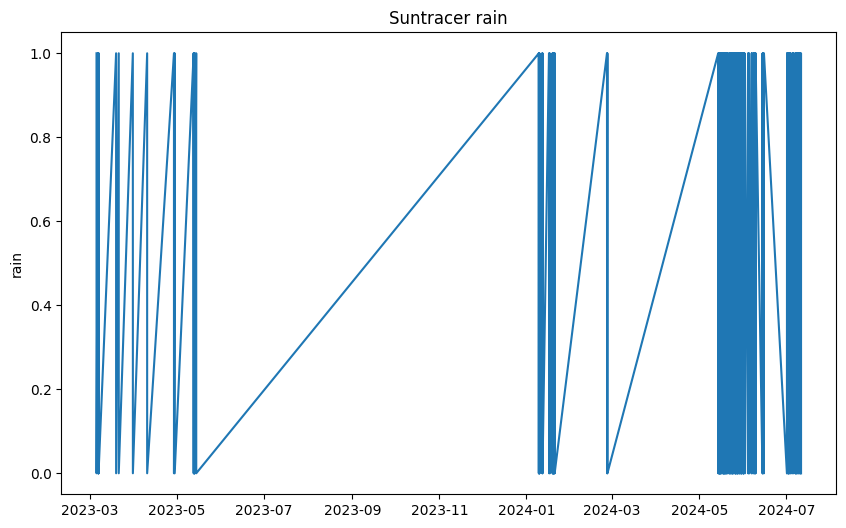

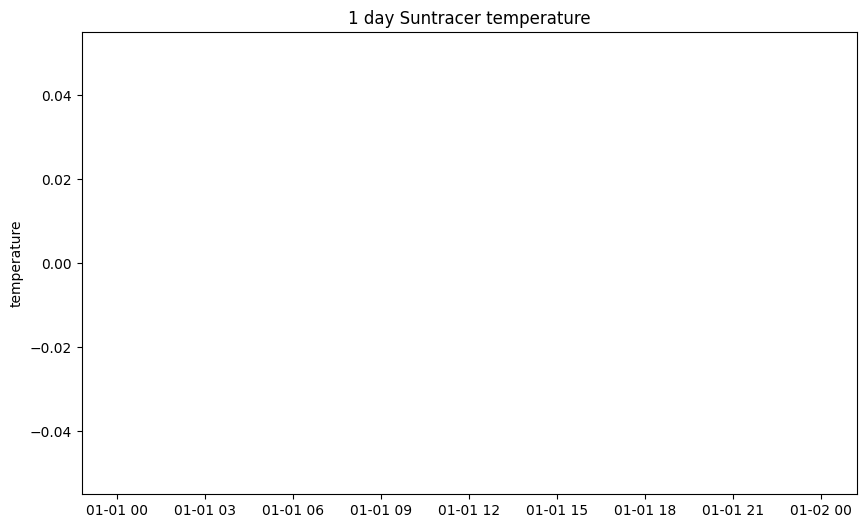

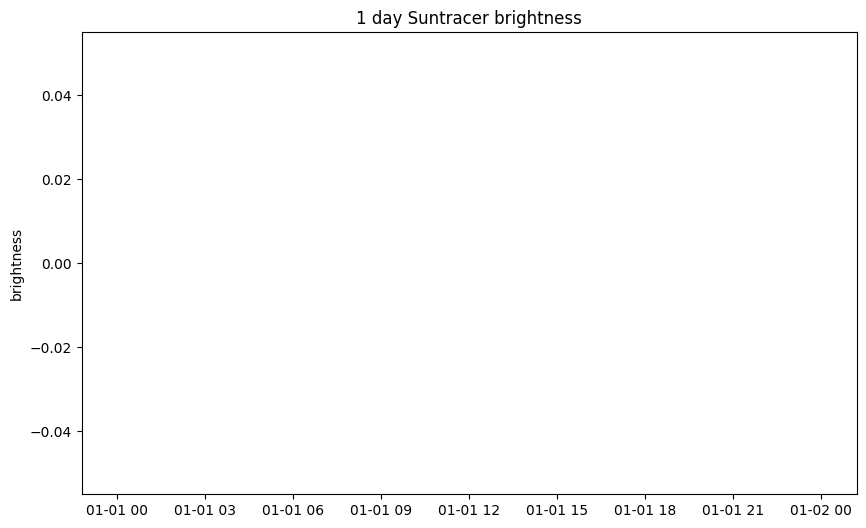

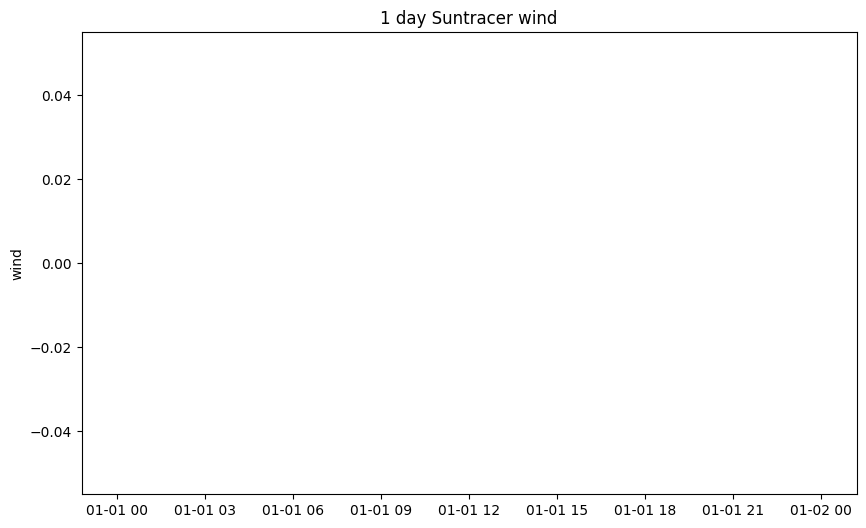

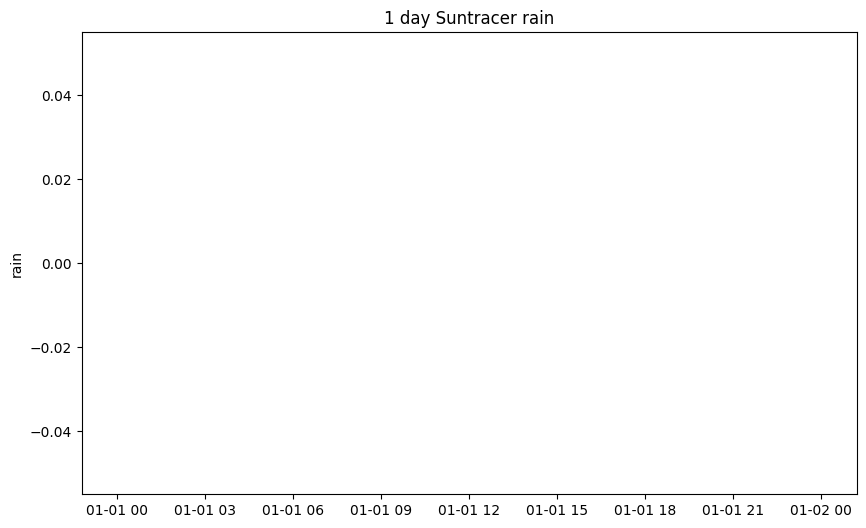

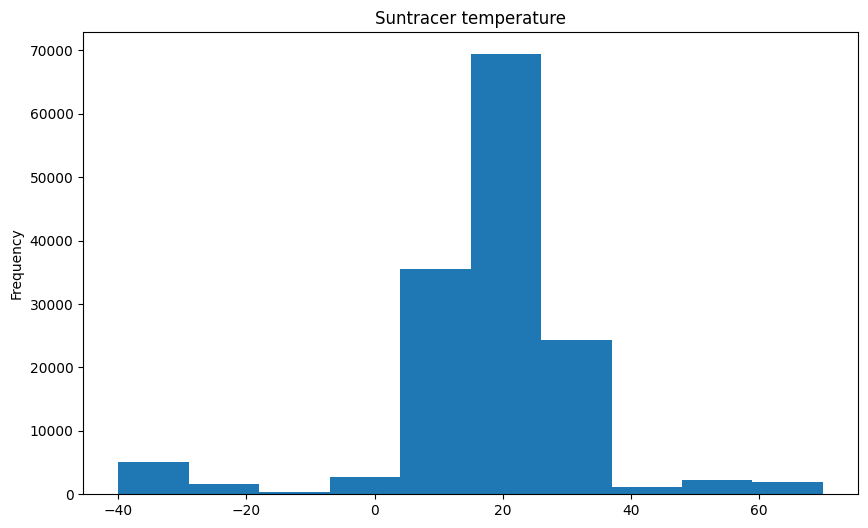

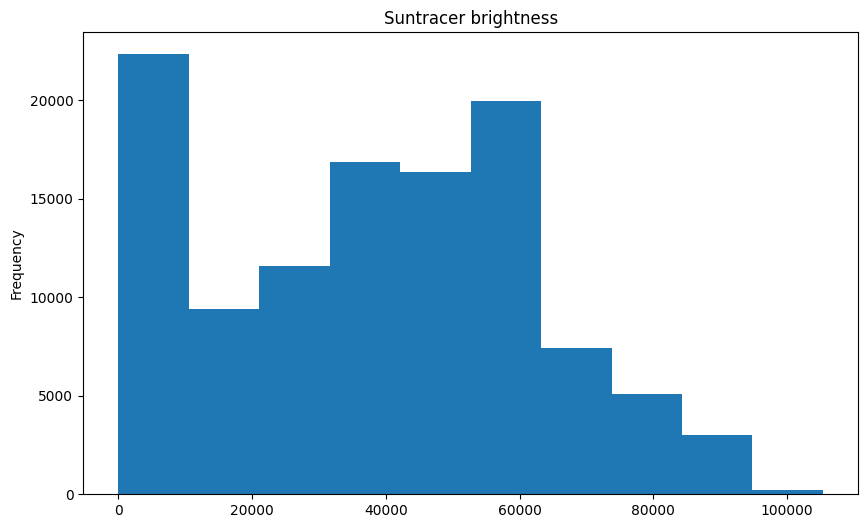

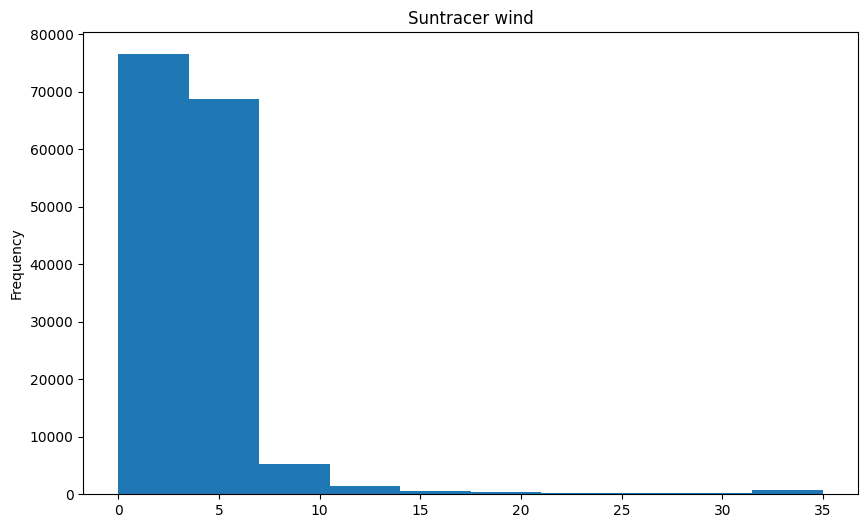

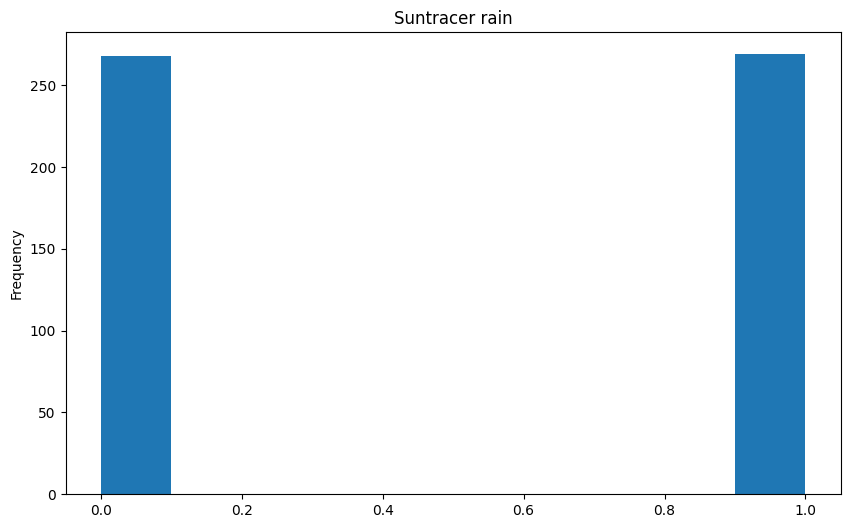

In [6]:
plot_data(df_temperature, 'temperature')
plot_data(df_brightness, 'brightness')
plot_data(df_wind, 'wind')
plot_data(df_rain, 'rain')
plot_day_data(df_temperature, 'temperature')
plot_day_data(df_brightness, 'brightness')
plot_day_data(df_wind, 'wind')
plot_day_data(df_rain, 'rain')
plot_hist(df_temperature, 'temperature')
plot_hist(df_brightness, 'brightness')
plot_hist(df_wind, 'wind')
plot_hist(df_rain, 'rain')

Debido a todos estos problemas, se ha optado por tomar únicamente el tramo entre marzo y mayo de 2023.

In [7]:
def reduce_df(df, start_date, end_date):
    return df[(df.index >= start_date) & (df.index <= end_date)]

In [8]:
reduced_df_temperature = reduce_df(df_temperature, '2023-03-01', '2023-05-15')
reduced_df_brightness = reduce_df(df_brightness, '2023-03-01', '2023-05-15')
reduced_df_wind = reduce_df(df_wind, '2023-03-01', '2023-05-15')
reduced_df_rain = reduce_df(df_rain, '2023-03-01', '2023-05-15')

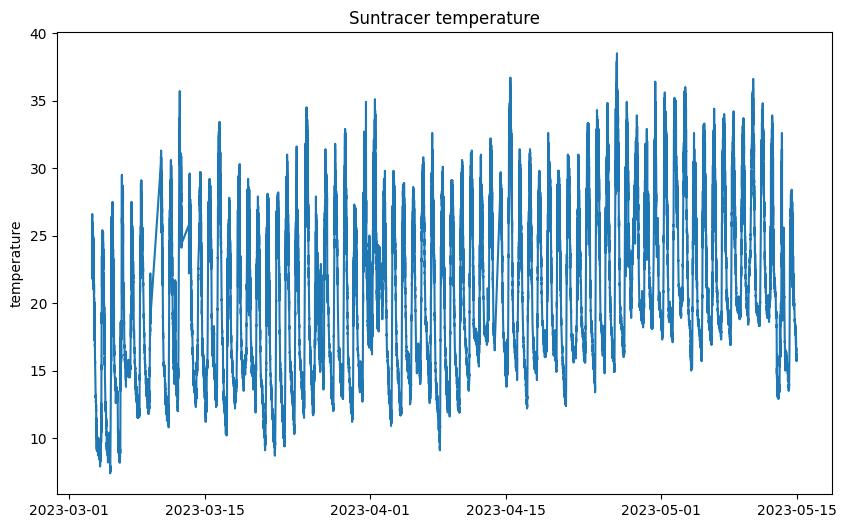

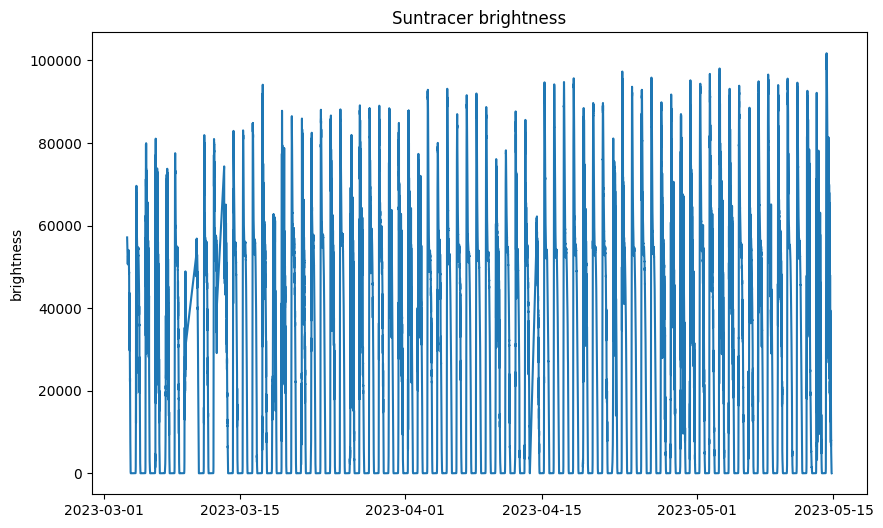

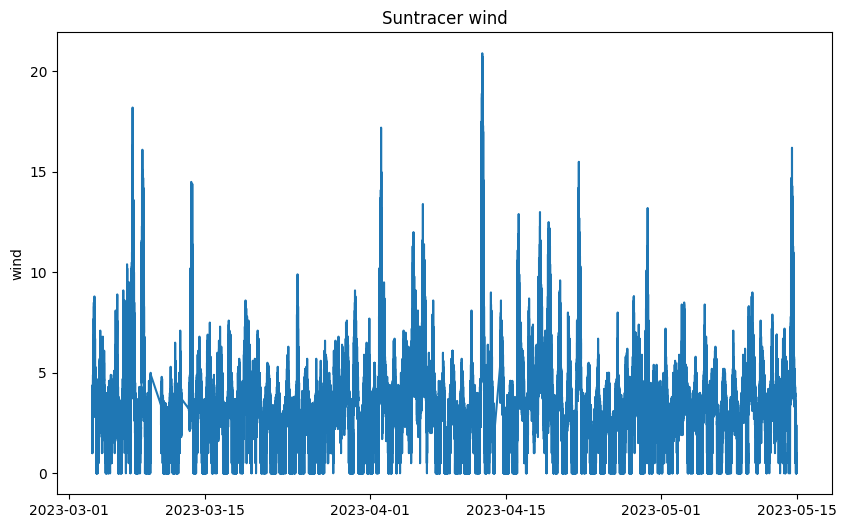

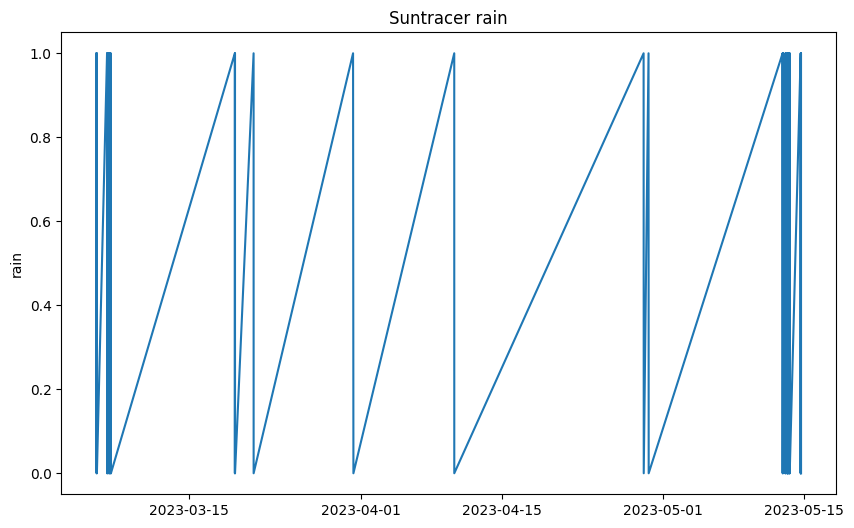

In [9]:
plot_data(reduced_df_temperature, 'temperature')
plot_data(reduced_df_brightness, 'brightness')
plot_data(reduced_df_wind, 'wind')
plot_data(reduced_df_rain, 'rain')

Registros duplicados

In [10]:
def delete_duplicates(df, col_name):
    print(col_name + ' - Número de registros duplicados:', df.index.duplicated().sum())
    if df.index.duplicated().sum() > 0:
        df = df.groupby(df.index).mean()
        print(col_name + ' - Número de registros tras eliminar duplicados:' + str(len(df)))
    else:
        print('No hay registros duplicados')
    return df
    

In [11]:
reduced_df_temperature = delete_duplicates(reduced_df_temperature, 'temperature')
reduced_df_brightness = delete_duplicates(reduced_df_brightness, 'brightness')
reduced_df_wind = delete_duplicates(reduced_df_wind, 'wind')
reduced_df_rain = delete_duplicates(reduced_df_rain, 'rain')

temperature - Número de registros duplicados: 491
temperature - Número de registros tras eliminar duplicados:71746
brightness - Número de registros duplicados: 479
brightness - Número de registros tras eliminar duplicados:54920
wind - Número de registros duplicados: 730
wind - Número de registros tras eliminar duplicados:84820
rain - Número de registros duplicados: 0
No hay registros duplicados


In [12]:
def fill_gaps_df(df,col_name, boolean=False):
    print(col_name + " - Original data: ", len(df), "rows")
    
    # Rellenamos los valores faltantes
    df = df.resample('min').asfreq()
    if boolean:
        df[col_name] = df[col_name].interpolate(method='ffill')
    else:
        df[col_name] = df[col_name].interpolate(method='linear', limit_direction='both')
    
    print(col_name + " - Updated data: ", len(df), "rows")
    
    return df

In [13]:
reduced_df_temperature = fill_gaps_df(reduced_df_temperature, 'temperature')
reduced_df_brightness = fill_gaps_df(reduced_df_brightness, 'brightness')
reduced_df_wind = fill_gaps_df(reduced_df_wind, 'wind')
reduced_df_rain = fill_gaps_df(reduced_df_rain, 'rain', boolean=True)

temperature - Original data:  71746 rows
temperature - Updated data:  104551 rows
brightness - Original data:  54920 rows
brightness - Updated data:  104283 rows
wind - Original data:  84820 rows
wind - Updated data:  104551 rows
rain - Original data:  64 rows
rain - Updated data:  100621 rows


C:\Users\IvO\AppData\Local\Temp\ipykernel_25852\3993579754.py:7: FutureWarning: Series.interpolate with method=ffill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col_name] = df[col_name].interpolate(method='ffill')


In [14]:
reduced_df_temperature

,temperature
timestamp,
2023-03-03 09:30:00,22.70
2023-03-03 09:31:00,22.20
2023-03-03 09:32:00,21.80
2023-03-03 09:33:00,22.10
2023-03-03 09:34:00,22.60
...,...
2023-05-14 23:56:00,16.00
2023-05-14 23:57:00,16.05
2023-05-14 23:58:00,16.10


In [15]:
reduced_df_wind

,wind
timestamp,
2023-03-03 09:30:00,3.600000
2023-03-03 09:31:00,3.650000
2023-03-03 09:32:00,3.700000
2023-03-03 09:33:00,3.000000
2023-03-03 09:34:00,3.400000
...,...
2023-05-14 23:56:00,0.913043
2023-05-14 23:57:00,0.956522
2023-05-14 23:58:00,1.000000


In [16]:
reduced_df_brightness

,brightness
timestamp,
2023-03-03 09:30:00,57139.200000
2023-03-03 09:31:00,57057.280000
2023-03-03 09:32:00,56934.400000
2023-03-03 09:33:00,56729.600000
2023-03-03 09:34:00,56606.720000
...,...
2023-05-14 19:28:00,8.000000
2023-05-14 19:29:00,5.000000
2023-05-14 19:30:00,3.333333


In [17]:
reduced_df_rain

,rain
timestamp,
2023-03-05 19:15:00,1.0
2023-03-05 19:16:00,1.0
2023-03-05 19:17:00,1.0
2023-03-05 19:18:00,1.0
2023-03-05 19:19:00,1.0
...,...
2023-05-14 16:11:00,1.0
2023-05-14 16:12:00,1.0
2023-05-14 16:13:00,1.0


Definimos datos de inicio y fin ignorando primer y último dia

In [18]:
reduced_df_temperature = reduced_df_temperature[(reduced_df_temperature.index >= '2023-03-06') & (reduced_df_temperature.index <= '2023-05-14')]
reduced_df_brightness = reduced_df_brightness[(reduced_df_brightness.index >= '2023-03-06') & (reduced_df_brightness.index <= '2023-05-14')]
reduced_df_wind = reduced_df_wind[(reduced_df_wind.index >= '2023-03-06') & (reduced_df_wind.index <= '2023-05-14')]
reduced_df_rain = reduced_df_rain[(reduced_df_rain.index >= '2023-03-06') & (reduced_df_rain.index <= '2023-05-14')]
len(reduced_df_temperature), len(reduced_df_brightness), len(reduced_df_wind), len(reduced_df_rain)

(99361, 99361, 99361, 99361)

Normalizamos los datos

In [19]:
def normalize_df(df):
    scaler = MinMaxScaler()
    df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
    return df_normalized, scaler

In [20]:
reduced_df_temperature, scaler_temperature = normalize_df(reduced_df_temperature)
reduced_df_brightness, scaler_brightness = normalize_df(reduced_df_brightness)
reduced_df_wind, scaler_wind = normalize_df(reduced_df_wind)

Por último, combinamos todos los datos en una misma tabla

In [21]:
# Merge all df into one
completed_df = pd.concat([reduced_df_temperature, reduced_df_brightness, reduced_df_wind, reduced_df_rain], axis=1)
completed_df

,temperature,brightness,wind,rain
timestamp,,,,
2023-03-06 00:00:00,0.151815,0.000024,0.186603,0.0
2023-03-06 00:01:00,0.158416,0.000024,0.220096,0.0
2023-03-06 00:02:00,0.160066,0.000024,0.181818,0.0
2023-03-06 00:03:00,0.161716,0.000024,0.220096,0.0
2023-03-06 00:04:00,0.158416,0.000025,0.229665,0.0
...,...,...,...,...
2023-05-13 23:56:00,0.231023,0.000025,0.162679,0.0
2023-05-13 23:57:00,0.237624,0.000025,0.153110,0.0
2023-05-13 23:58:00,0.238724,0.000025,0.191388,0.0


## Normalización de los valores + añadir periodicidad

In [22]:
day = 60*60*24
year = 365.2425*day

completed_df['seconds'] = completed_df.index.map(pd.Timestamp.timestamp)

# A partir del seno y coseno podemos trabajar también la periodicidad de los datos. Concretamente, la de los dias y el año.

completed_df['day_sin'] = np.sin(completed_df['seconds'] * (2 * np.pi / year))
completed_df['day_cos'] = np.cos(completed_df['seconds'] * (2 * np.pi / year))
completed_df['year_sin'] = np.sin(completed_df['seconds'] * (2 * np.pi / year))
completed_df['year_cos'] = np.cos(completed_df['seconds'] * (2 * np.pi / year))

completed_df.drop(columns=['seconds'], inplace=True)

completed_df

,temperature,brightness,wind,rain,day_sin,day_cos,year_sin,year_cos
timestamp,,,,,,,,
2023-03-06 00:00:00,0.151815,0.000024,0.186603,0.0,0.892796,0.450461,0.892796,0.450461
2023-03-06 00:01:00,0.158416,0.000024,0.220096,0.0,0.892802,0.450450,0.892802,0.450450
2023-03-06 00:02:00,0.160066,0.000024,0.181818,0.0,0.892807,0.450439,0.892807,0.450439
2023-03-06 00:03:00,0.161716,0.000024,0.220096,0.0,0.892812,0.450429,0.892812,0.450429
2023-03-06 00:04:00,0.158416,0.000025,0.229665,0.0,0.892818,0.450418,0.892818,0.450418
...,...,...,...,...,...,...,...,...
2023-05-13 23:56:00,0.231023,0.000025,0.162679,0.0,0.752028,-0.659131,0.752028,-0.659131
2023-05-13 23:57:00,0.237624,0.000025,0.153110,0.0,0.752020,-0.659140,0.752020,-0.659140
2023-05-13 23:58:00,0.238724,0.000025,0.191388,0.0,0.752012,-0.659149,0.752012,-0.659149


## 5. Creación y estudio de predicciones con LSMT.

Las redes Long Shot Memory Term son las redes neuronales indicadas para llevar a cabo la predicción de valores futuros dentro de series temporales. Dentro de este cuaderno analizaremos los resultados a partir de una implementación manual y con el uso de métodos ya definidos por Tensorflow/PyTorch 

In [27]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, InputLayer, TimeDistributed, RepeatVector
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError, RootMeanSquaredError
from tensorflow.keras.losses import MeanSquaredError as mse_tf, MeanAbsoluteError as mae_tf

Antes de comenzar a definir el modelo será necesario detallar el número de datos necesarios para la entrada y la salida. En este caso, se ha optado por predecir hasta 15 minutos en el futuro a partir de los datos de los 60 minutos anteriores. Esta funcionalidad se cumple con el método split_sequences(). Las entradas (input) se localizarán en X, mientras que y será el resultado que dan. 

In [30]:
def split_sequence(df, window_size = 60, target_size = 15):
    X, y = [], []
    for i in range(len(df)-window_size-target_size):
        X.append(df.iloc[i:(i+window_size)].values)
        row = df.iloc[(i+window_size):(i+window_size+target_size)].values
        y.append(row[:, :-4].flatten())
    return np.array(X), np.array(y)

In [31]:
WINDOW_SIZE = 60
TARGET_SIZE = 15
X, y = split_sequence(completed_df, WINDOW_SIZE, TARGET_SIZE)
X.shape, y.shape

((99286, 60, 8), (99286, 60))

In [51]:
X

array([[[ 1.51815182e-01,  2.42707140e-05,  1.86602871e-01, ...,
          4.50460605e-01,  8.92796306e-01,  4.50460605e-01],
        [ 1.58415842e-01,  2.43427340e-05,  2.20095694e-01, ...,
          4.50449939e-01,  8.92801687e-01,  4.50449939e-01],
        [ 1.60066007e-01,  2.44147539e-05,  1.81818182e-01, ...,
          4.50439273e-01,  8.92807068e-01,  4.50439273e-01],
        ...,
        [ 1.15511551e-01,  2.83758497e-05,  1.84210526e-01, ...,
          4.49852556e-01,  8.93102837e-01,  4.49852556e-01],
        [ 1.13861386e-01,  2.84478696e-05,  2.05741627e-01, ...,
          4.49841887e-01,  8.93108211e-01,  4.49841887e-01],
        [ 1.12211221e-01,  2.85198895e-05,  1.81818182e-01, ...,
          4.49831218e-01,  8.93113585e-01,  4.49831218e-01]],

       [[ 1.58415842e-01,  2.43427340e-05,  2.20095694e-01, ...,
          4.50449939e-01,  8.92801687e-01,  4.50449939e-01],
        [ 1.60066007e-01,  2.44147539e-05,  1.81818182e-01, ...,
          4.50439273e-01,  8.92807068e

In [52]:
y

array([[1.05610561e-01, 2.85919094e-05, 8.13397129e-02, ...,
        2.96001883e-05, 1.77033493e-01, 0.00000000e+00],
       [1.04510451e-01, 2.86639293e-05, 1.38755981e-01, ...,
        2.96722083e-05, 1.86602871e-01, 0.00000000e+00],
       [1.03410341e-01, 2.87359493e-05, 1.91387560e-01, ...,
        2.97442282e-05, 1.77033493e-01, 0.00000000e+00],
       ...,
       [2.47524752e-01, 2.35770763e-05, 1.86602871e-01, ...,
        2.48869139e-05, 1.53110048e-01, 0.00000000e+00],
       [2.46699670e-01, 2.36706361e-05, 2.00956938e-01, ...,
        2.49804737e-05, 1.91387560e-01, 0.00000000e+00],
       [2.45874587e-01, 2.37641959e-05, 1.91387560e-01, ...,
        2.50740335e-05, 1.81818182e-01, 0.00000000e+00]])

In [53]:
lsmt_separation_rows = int(len(X)*0.8)
X_train, X_test = X[:lsmt_separation_rows], X[lsmt_separation_rows:]
y_train, y_test = y[:lsmt_separation_rows], y[lsmt_separation_rows:]

len(X_train), len(X_test), len(y_train), len(y_test)

(79428, 19858, 79428, 19858)

In [32]:
HandMadeLSTM = Sequential()
HandMadeLSTM.add(InputLayer((WINDOW_SIZE, len(completed_df.columns))))
HandMadeLSTM.add(LSTM(64, activation='relu'))
HandMadeLSTM.add(Dense(TARGET_SIZE*(len(completed_df.columns)-4)))

HandMadeLSTM.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 60)             │         3,900 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,588 (88.23 KB)

 Trainable params: 22,588 (88.23 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
modelPath = '../LSMTTensorflow/bestModelMultiParameter.keras'
checkpoints = ModelCheckpoint(modelPath, save_best_only=True)
HandMadeLSTM.compile(optimizer=Adam(learning_rate=0.001), loss=mse_tf(), metrics=[mae_tf(), RootMeanSquaredError()])

In [54]:
HandMadeLSTM.fit(X_train, y_train, epochs=20, validation_split=0.2, callbacks=[checkpoints])

Epoch 1/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 27s 13ms/step - loss: 0.0076 - mean_absolute_error: 0.0441 - root_mean_squared_error: 0.0800 - val_loss: 0.0022 - val_mean_absolute_error: 0.0251 - val_root_mean_squared_error: 0.0471
Epoch 2/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - loss: 0.0016 - mean_absolute_error: 0.0197 - root_mean_squared_error: 0.0402 - val_loss: 0.0021 - val_mean_absolute_error: 0.0225 - val_root_mean_squared_error: 0.0459
Epoch 3/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 26s 13ms/step - loss: 0.0015 - mean_absolute_error: 0.0187 - root_mean_squared_error: 0.0388 - val_loss: 0.0021 - val_mean_absolute_error: 0.0225 - val_root_mean_squared_error: 0.0459
Epoch 4/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 26s 13ms/step - loss: 0.0014 - mean_absolute_error: 0.0183 - root_mean_squared_error: 0.0380 - val_loss: 0.0020 - val_mean_absolute_error: 0.0217 - val_root_mean_squared_error: 0.0448
Epoch 5/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 26s 13ms/step - loss: 0.0015 - mean_absolute_error: 0.

In [34]:
HandMadeLSTM = load_model(modelPath)

In [57]:
test_predictions = HandMadeLSTM.predict(X_test)
test_predictions.shape

621/621 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


(19858, 60)

In [58]:
y_test

array([[3.94939494e-01, 5.05474830e-05, 1.72248804e-01, ...,
        5.30297097e-04, 1.33971292e-01, 0.00000000e+00],
       [3.96039604e-01, 5.06360075e-05, 1.86602871e-01, ...,
        5.91485223e-04, 1.67464115e-01, 0.00000000e+00],
       [3.97689769e-01, 5.07245320e-05, 1.77033493e-01, ...,
        7.13861477e-04, 1.72248804e-01, 0.00000000e+00],
       ...,
       [2.47524752e-01, 2.35770763e-05, 1.86602871e-01, ...,
        2.48869139e-05, 1.53110048e-01, 0.00000000e+00],
       [2.46699670e-01, 2.36706361e-05, 2.00956938e-01, ...,
        2.49804737e-05, 1.91387560e-01, 0.00000000e+00],
       [2.45874587e-01, 2.37641959e-05, 1.91387560e-01, ...,
        2.50740335e-05, 1.81818182e-01, 0.00000000e+00]])

In [59]:
# Destransformamos los datos
def inverse_transform_dataset(predictions, test):
    test_predictions_temperature = scaler_temperature.inverse_transform(predictions[:, ::4]).flatten()
    test_predictions_brightness = scaler_brightness.inverse_transform(predictions[:, 1::4]).flatten()
    test_predictions_wind = scaler_wind.inverse_transform(predictions[:, 2::4]).flatten()
    test_predictions_rain = predictions[:, 3::4].flatten()

    y_test_temperature = scaler_temperature.inverse_transform(test[:, ::4]).flatten()
    y_test_brightness = scaler_brightness.inverse_transform(test[:, 1::4]).flatten()
    y_test_wind = scaler_wind.inverse_transform(test[:, 2::4]).flatten()
    y_test_rain = test[:, 3::4].flatten()
    
    return test_predictions_temperature, test_predictions_brightness, test_predictions_wind, test_predictions_rain, y_test_temperature, y_test_brightness, y_test_wind, y_test_rain

test_predictions_temperature, test_predictions_brightness, test_predictions_wind, test_predictions_rain, y_test_temperature, y_test_brightness, y_test_wind, y_test_rain = inverse_transform_dataset(test_predictions, y_test)

In [60]:
def plot_predictions(y_test, test_predictions, col_name):
    plt.figure(figsize=(10,6))
    plt.plot(y_test, label='True')
    plt.plot(test_predictions, label='Predicted')
    plt.title('Suntracer ' + col_name)
    plt.ylabel(col_name)
    plt.legend()
    plt.show()
    
def plot_predictions_day(y_test, test_predictions, col_name):
    plt.figure(figsize=(10,6))
    plt.plot(y_test[:96], label='True')
    plt.plot(test_predictions[:96], label='Predicted')
    plt.title('Suntracer ' + col_name + ' - 1 day')
    plt.ylabel(col_name)
    plt.legend()
    plt.show()

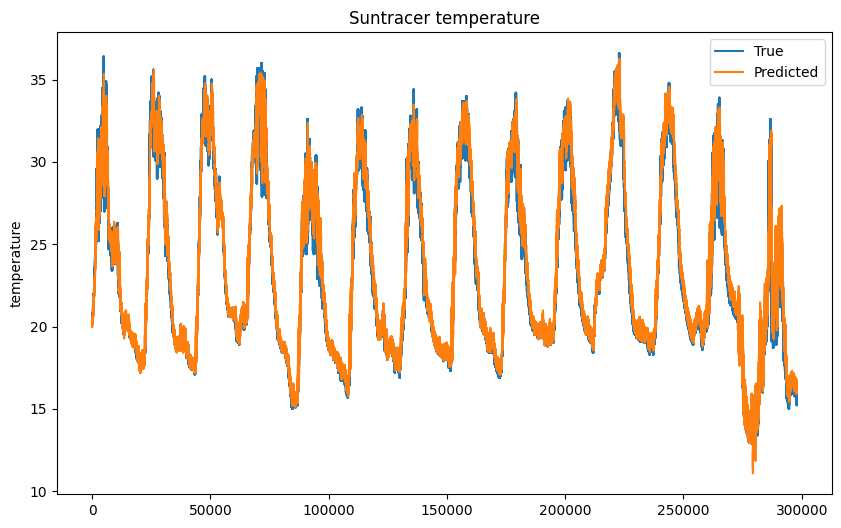

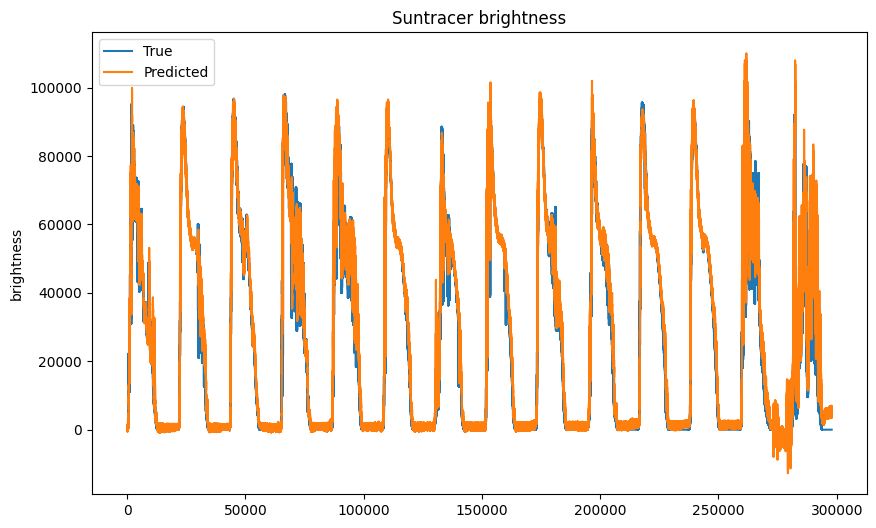

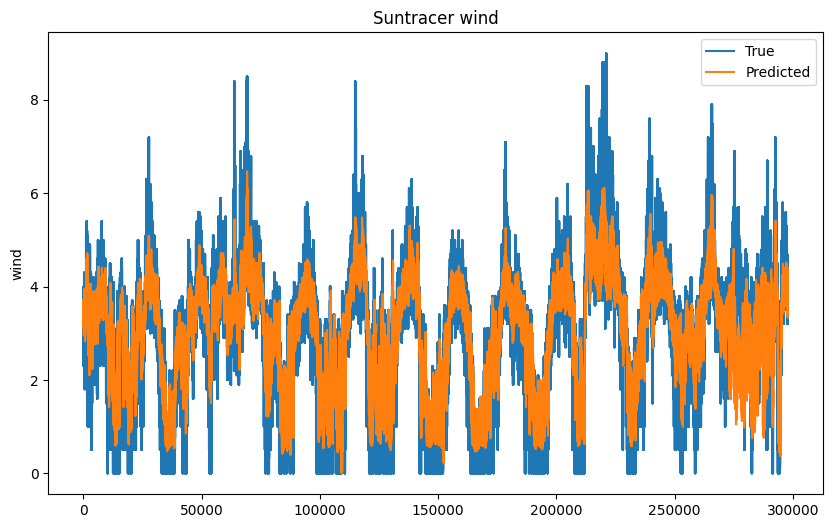

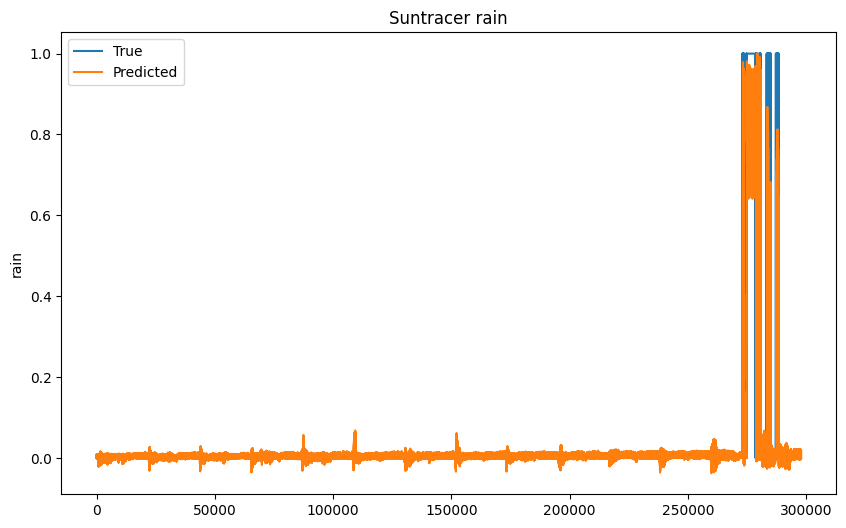

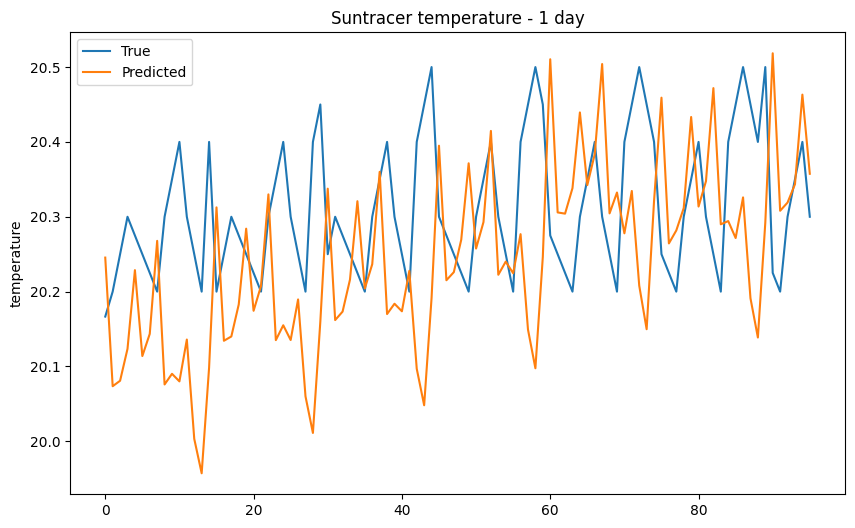

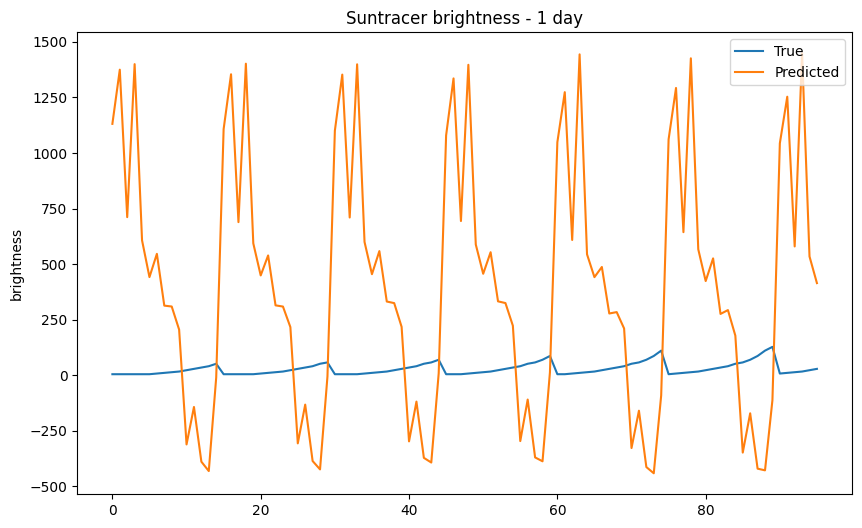

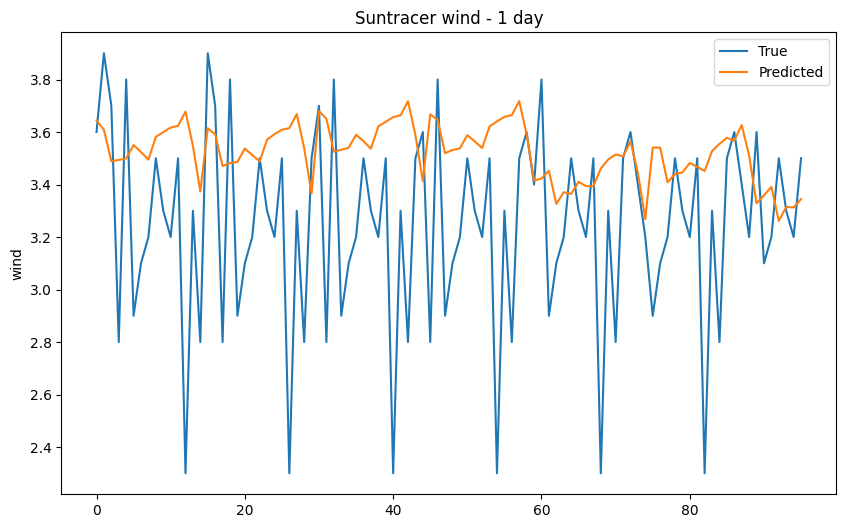

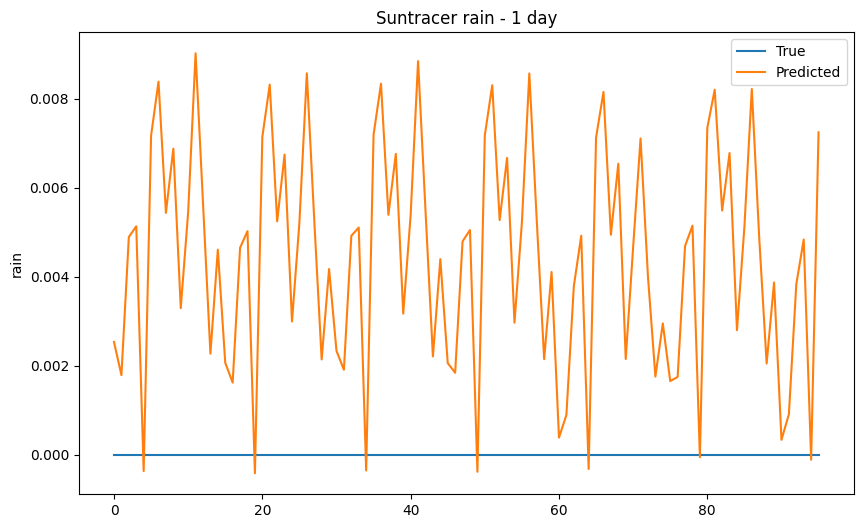

In [61]:
plot_predictions(y_test_temperature, test_predictions_temperature, 'temperature')
plot_predictions(y_test_brightness, test_predictions_brightness, 'brightness')
plot_predictions(y_test_wind, test_predictions_wind, 'wind')
plot_predictions(y_test_rain, test_predictions_rain, 'rain')

plot_predictions_day(y_test_temperature, test_predictions_temperature, 'temperature')
plot_predictions_day(y_test_brightness, test_predictions_brightness, 'brightness')
plot_predictions_day(y_test_wind, test_predictions_wind, 'wind')
plot_predictions_day(y_test_rain, test_predictions_rain, 'rain')

In [65]:
# Evaluate the predictions
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_predictions(y_test, test_predictions, name):
    print(name +' - MSE:', mean_squared_error(y_test, test_predictions))
    print(name +' - MAE:', mean_absolute_error(y_test, test_predictions))
    print(name +' - RMSE:', np.sqrt(mean_squared_error(y_test, test_predictions)))
    
evaluate_predictions(y_test_temperature, test_predictions_temperature, 'temperature')
evaluate_predictions(y_test_brightness, test_predictions_brightness, 'brightness')
evaluate_predictions(y_test_wind, test_predictions_wind, 'wind')
evaluate_predictions(y_test_rain, test_predictions_rain, 'rain')

temperature - MSE: 2.2907979314573317
temperature - MAE: 0.9500675466786321
temperature - RMSE: 1.5135382160544648
brightness - MSE: 129674133.01978192
brightness - MAE: 7321.635746084667
brightness - RMSE: 11387.455072130117
wind - MSE: 1.4457233095638224
wind - MAE: 0.9754278806471574
wind - RMSE: 1.2023823474934345
rain - MSE: 0.01817602137013809
rain - MAE: 0.03204943279859917
rain - RMSE: 0.1348184756260732


### Multistep / Predecir valores dentro de 60 minutos

Evaluamos para 60 minutos, 360 minutos y 720 minutos

In [66]:
horizons = [60, 360, 720]

Epoch 1/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 3s 994us/step - loss: 0.0158 - mean_absolute_error: 0.0654 - root_mean_squared_error: 0.1187 - val_loss: 0.0048 - val_mean_absolute_error: 0.0349 - val_root_mean_squared_error: 0.0696
Epoch 2/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 2s 920us/step - loss: 0.0042 - mean_absolute_error: 0.0315 - root_mean_squared_error: 0.0646 - val_loss: 0.0050 - val_mean_absolute_error: 0.0372 - val_root_mean_squared_error: 0.0704
Epoch 3/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 2s 886us/step - loss: 0.0041 - mean_absolute_error: 0.0315 - root_mean_squared_error: 0.0642 - val_loss: 0.0046 - val_mean_absolute_error: 0.0351 - val_root_mean_squared_error: 0.0677
Epoch 4/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 2s 882us/step - loss: 0.0041 - mean_absolute_error: 0.0312 - root_mean_squared_error: 0.0641 - val_loss: 0.0045 - val_mean_absolute_error: 0.0353 - val_root_mean_squared_error: 0.0672
Epoch 5/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 2s 891us/step - loss: 0.0039 - mean_absolute_error: 0.

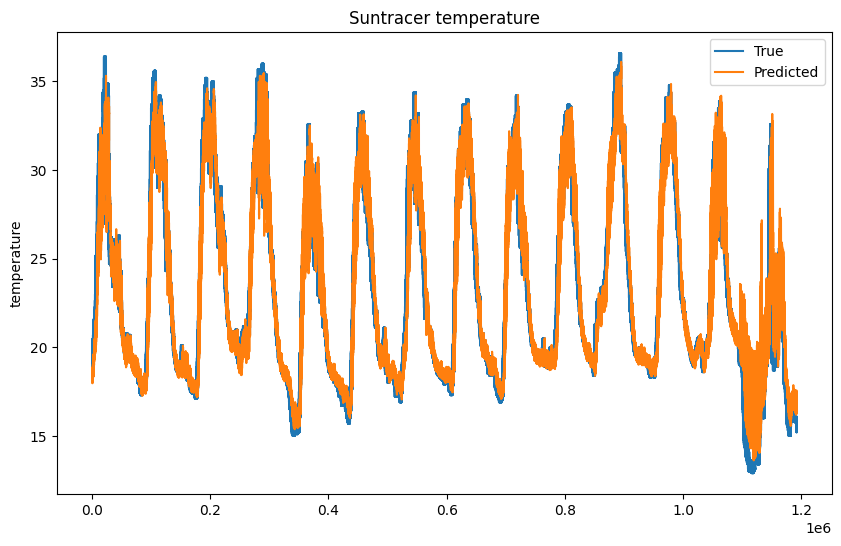

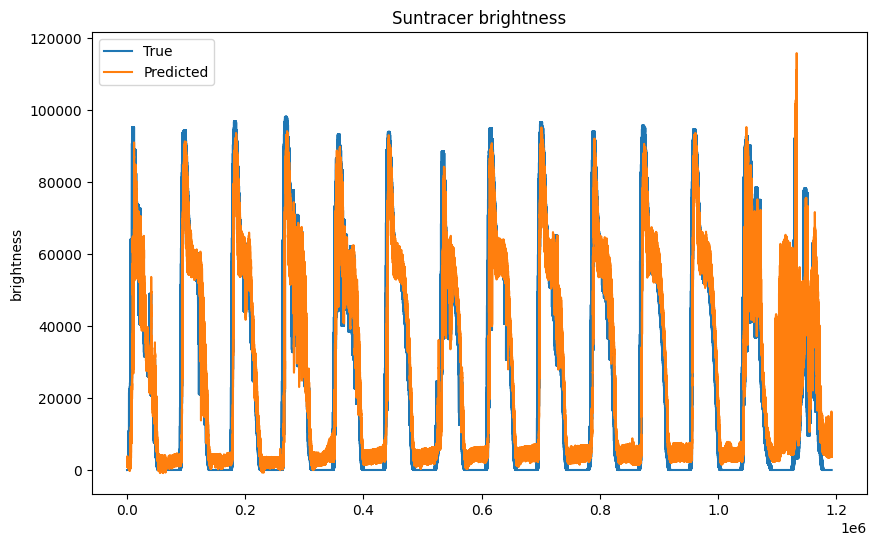

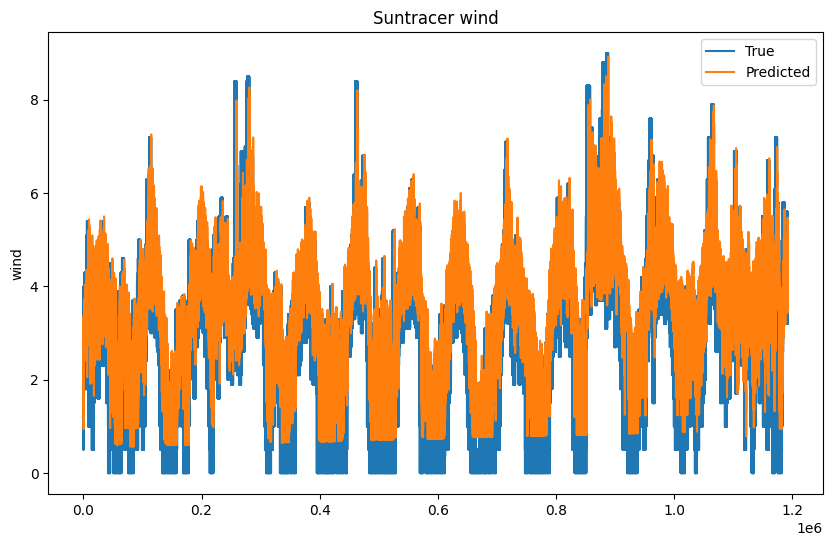

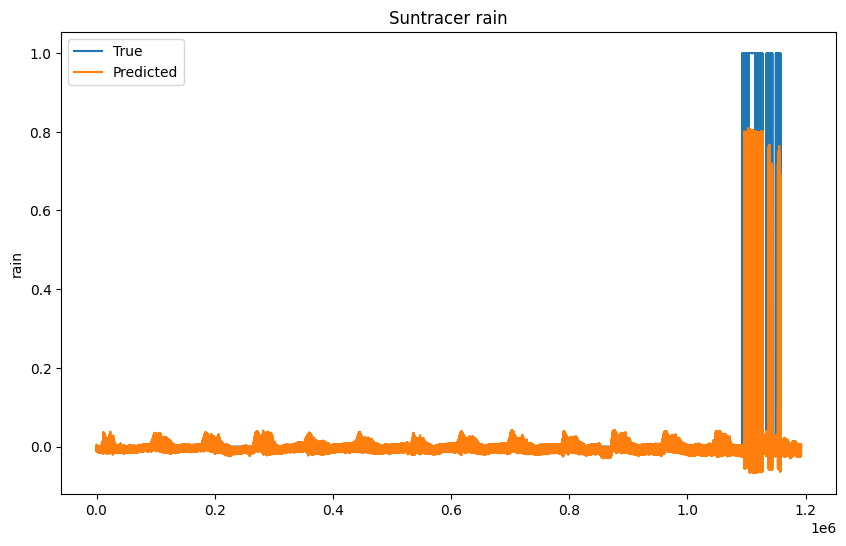

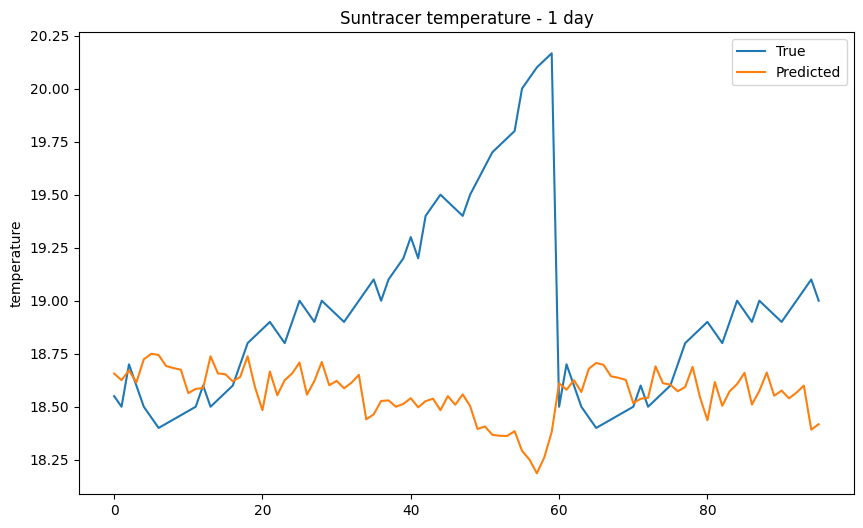

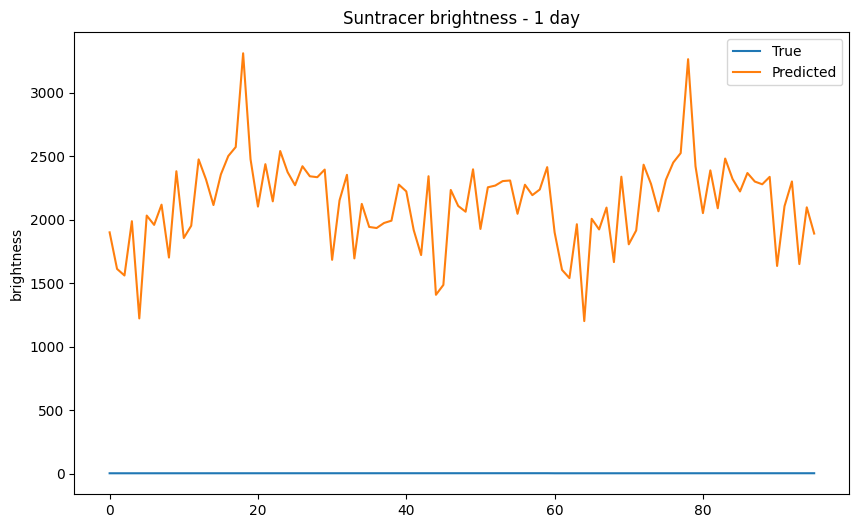

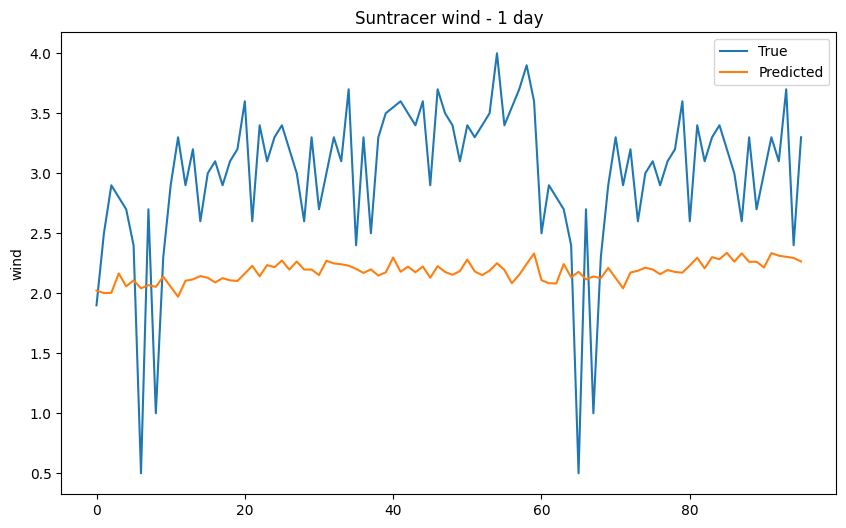

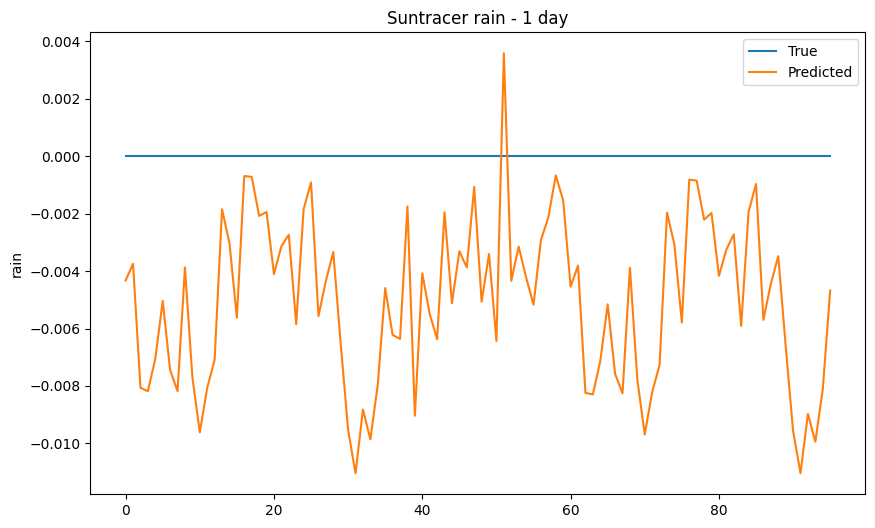

temperature - MSE: 1.9542758585955888
temperature - MAE: 0.8977872280792667
temperature - RMSE: 1.3979541689896664
brightness - MSE: 137702002.00685397
brightness - MAE: 7224.129482272552
brightness - RMSE: 11734.649632897183
wind - MSE: 1.2409037539815442
wind - MAE: 0.8681176624082653
wind - RMSE: 1.1139585961702276
rain - MSE: 0.016902070301610877
rain - MAE: 0.02697231000923354
rain - RMSE: 0.1300079624546546
Epoch 1/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0268 - mean_absolute_error: 0.0997 - root_mean_squared_error: 0.1615 - val_loss: 0.0193 - val_mean_absolute_error: 0.0828 - val_root_mean_squared_error: 0.1390
Epoch 2/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0175 - mean_absolute_error: 0.0784 - root_mean_squared_error: 0.1324 - val_loss: 0.0185 - val_mean_absolute_error: 0.0781 - val_root_mean_squared_error: 0.1359
Epoch 3/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0161 - mean_absolute_error: 0.0743 - root_mean_squared_error: 0.1270 - 

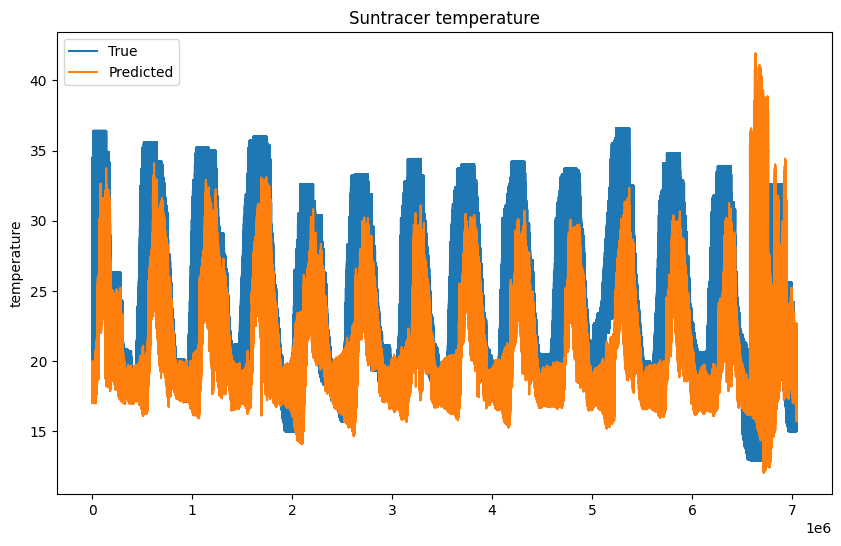

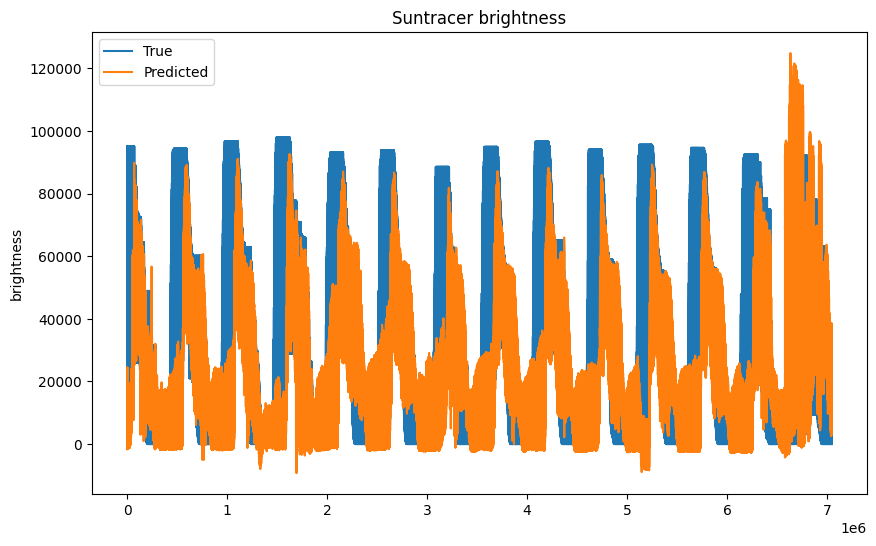

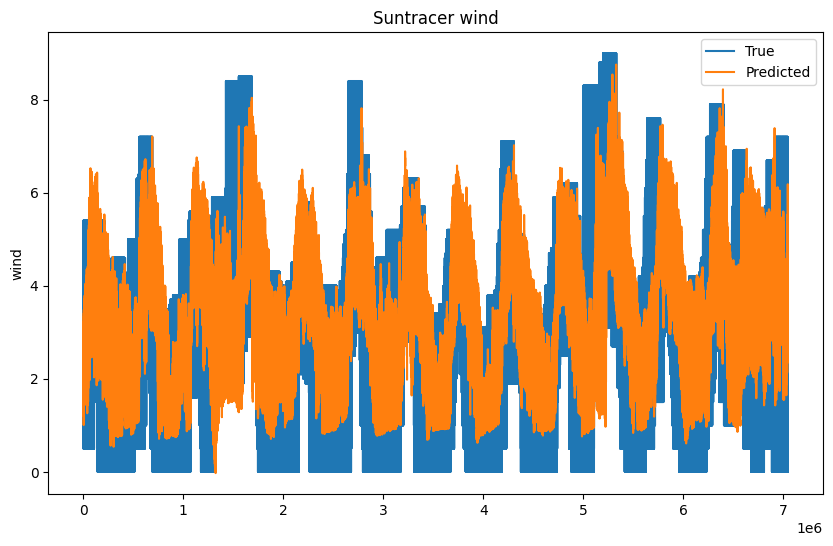

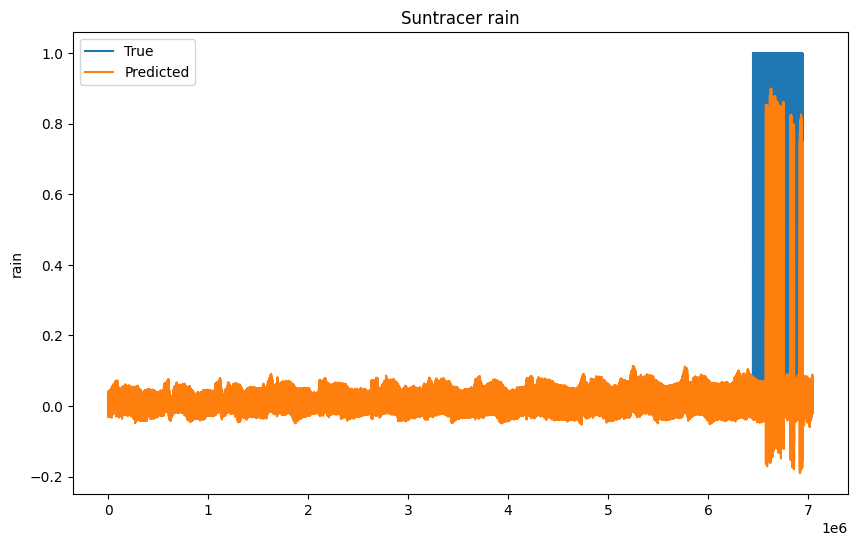

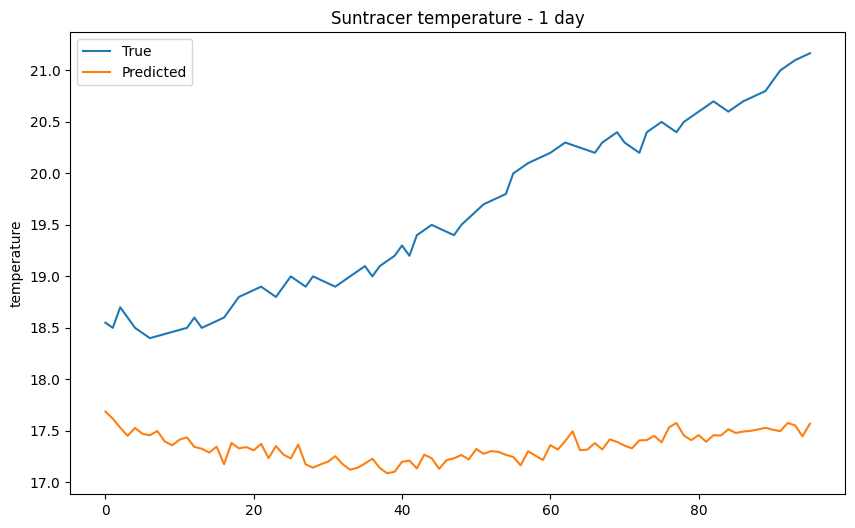

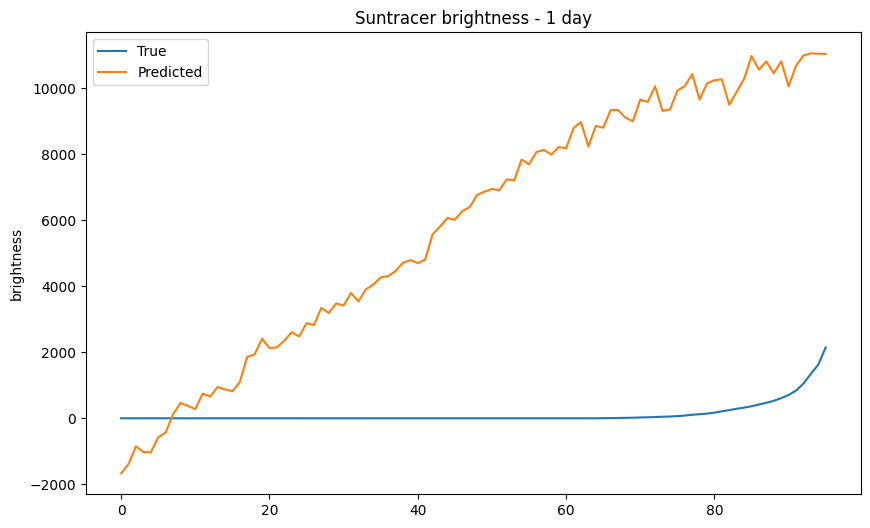

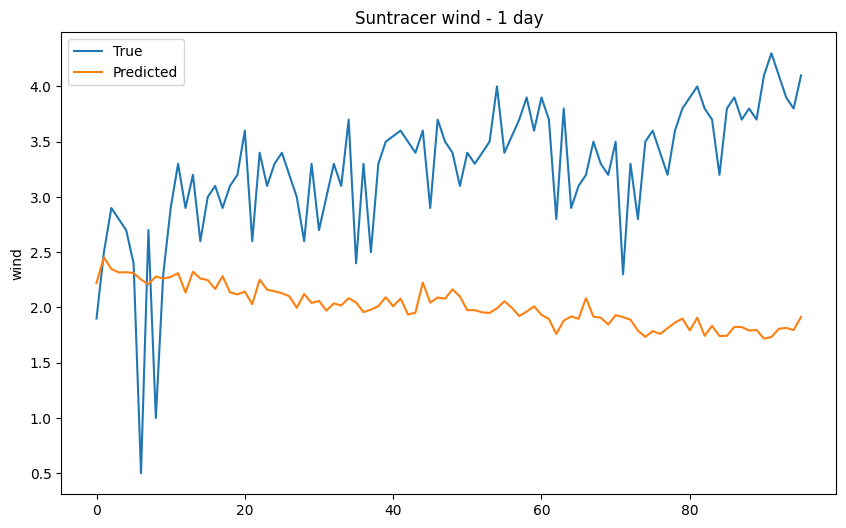

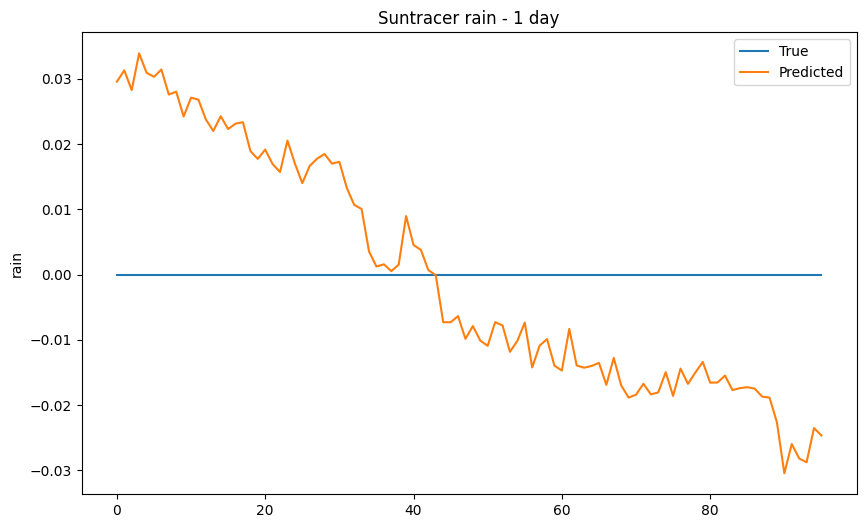

temperature - MSE: 23.265983866003445
temperature - MAE: 3.3697149334444765
temperature - RMSE: 4.823482545423322
brightness - MSE: 685807571.1178238
brightness - MAE: 18235.749790460563
brightness - RMSE: 26187.927965339753
wind - MSE: 2.16677458246071
wind - MAE: 1.2054105496591512
wind - RMSE: 1.4719968011041022
rain - MSE: 0.023016114525971833
rain - MAE: 0.03681892864280044
rain - RMSE: 0.1517106275973171
Epoch 1/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0295 - mean_absolute_error: 0.1087 - root_mean_squared_error: 0.1699 - val_loss: 0.0189 - val_mean_absolute_error: 0.0848 - val_root_mean_squared_error: 0.1375
Epoch 2/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0190 - mean_absolute_error: 0.0845 - root_mean_squared_error: 0.1379 - val_loss: 0.0183 - val_mean_absolute_error: 0.0825 - val_root_mean_squared_error: 0.1351
Epoch 3/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0182 - mean_absolute_error: 0.0819 - root_mean_squared_error: 0.1349 - val

c:\Users\IvO\Desktop\testGit\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


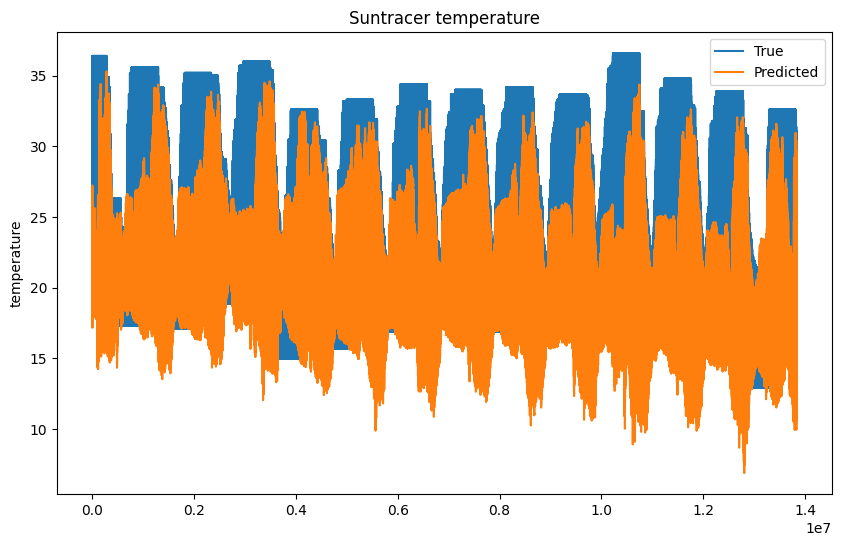

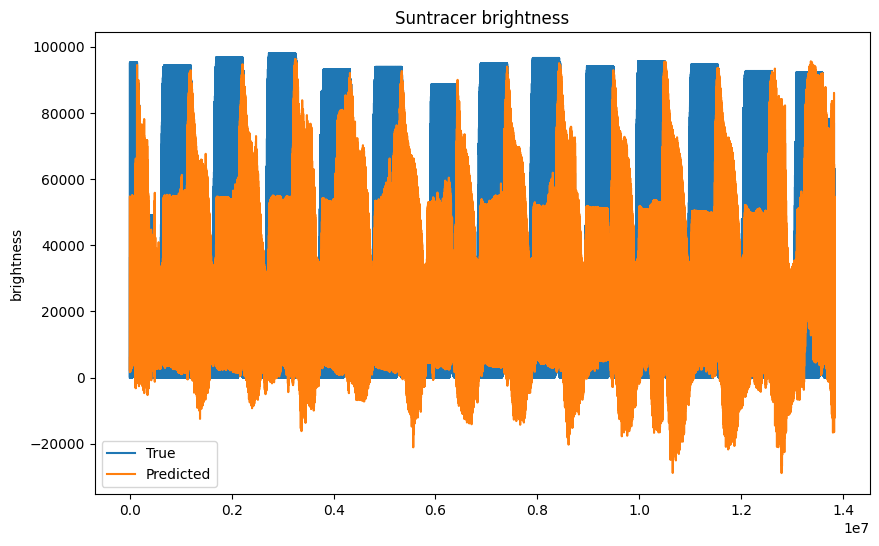

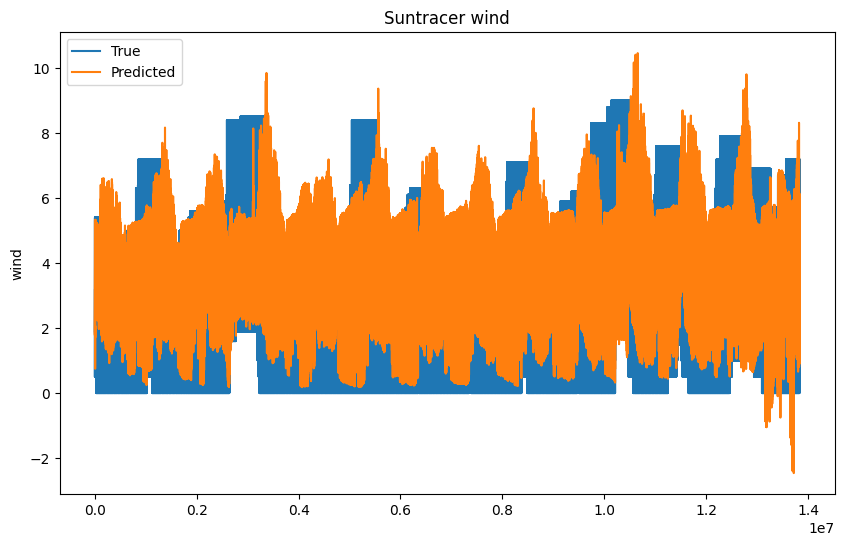

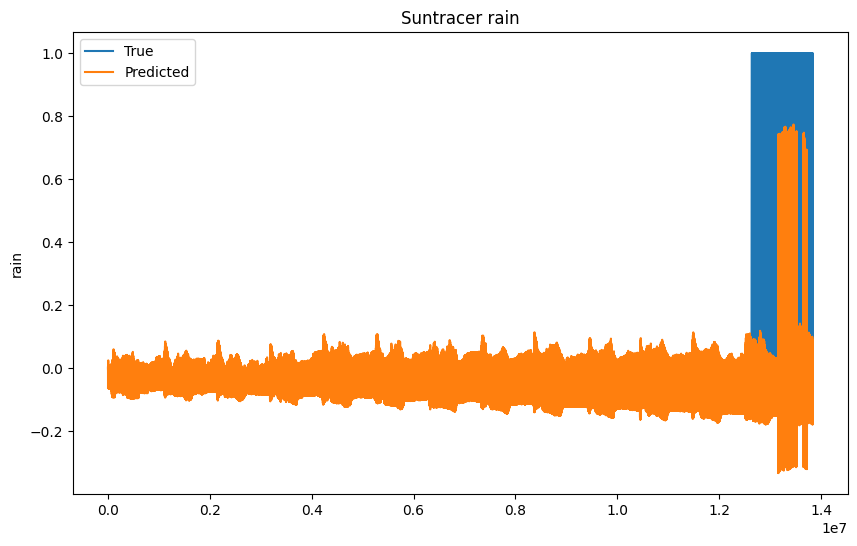

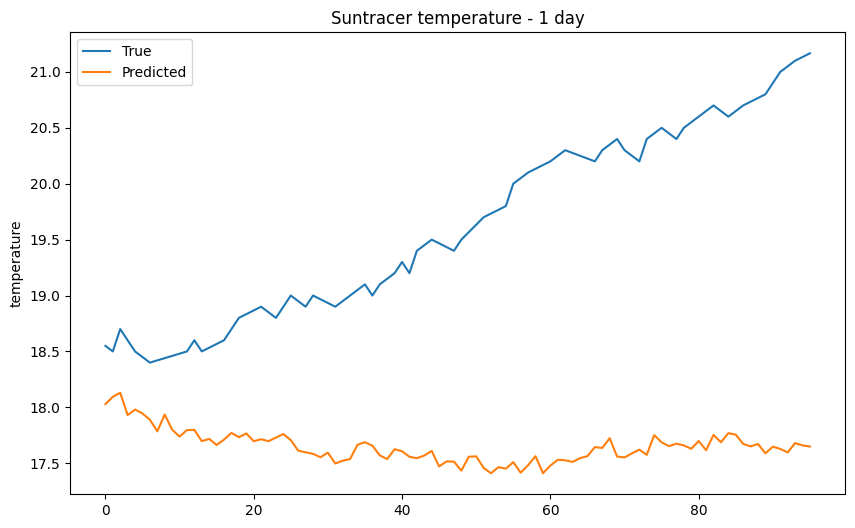

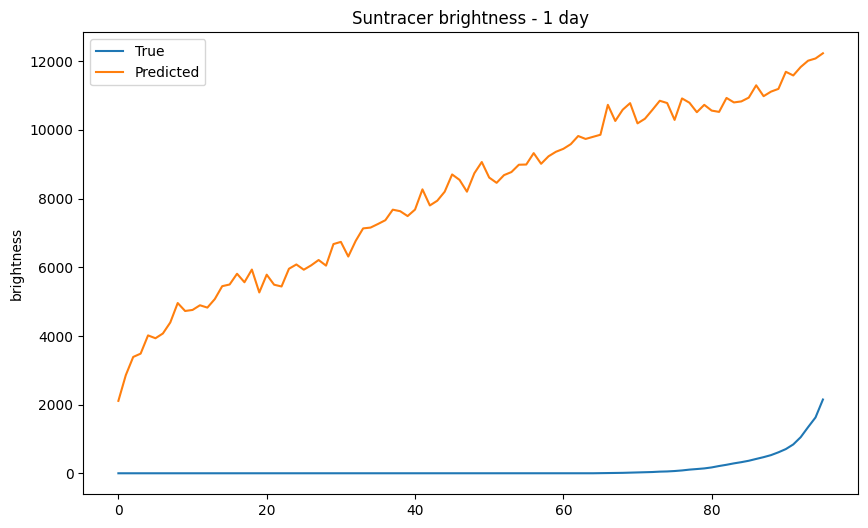

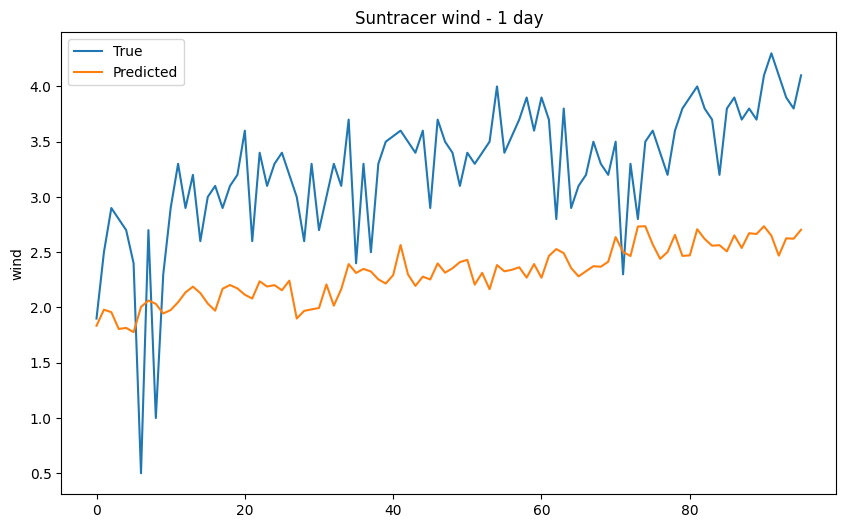

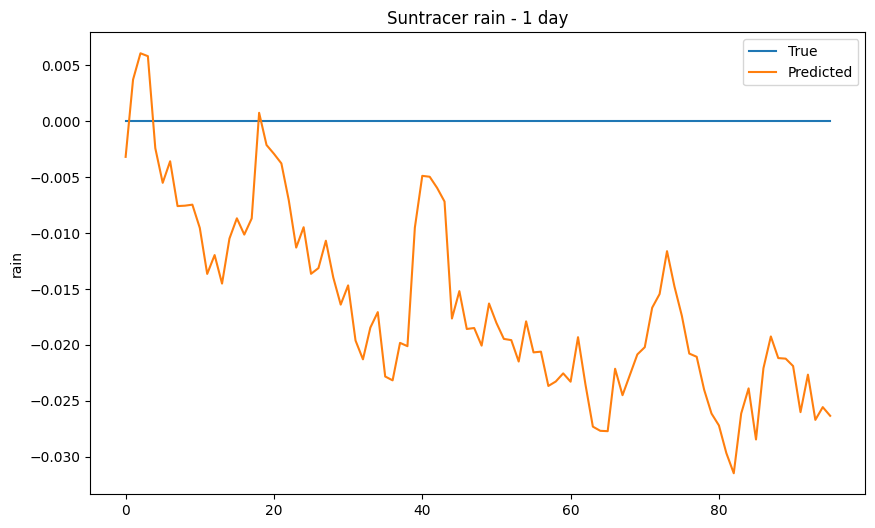

temperature - MSE: 27.296888804923253
temperature - MAE: 4.112183924883726
temperature - RMSE: 5.22464245713745
brightness - MSE: 555940162.1661854
brightness - MAE: 16818.027935719172
brightness - RMSE: 23578.383366257014
wind - MSE: 2.4272999722364927
wind - MAE: 1.2657656765128125
wind - RMSE: 1.5579794518017536
rain - MSE: 0.031715861689961905
rain - MAE: 0.08177122218266879
rain - RMSE: 0.17808947664014824


In [67]:
for horizon in horizons:
    X, y = split_sequence(completed_df, 1, horizon)
    X_train, X_test = X[:lsmt_separation_rows], X[lsmt_separation_rows:]
    y_train, y_test = y[:lsmt_separation_rows], y[lsmt_separation_rows:]

    HandMadeLSTM = Sequential()
    HandMadeLSTM.add(InputLayer((1, len(completed_df.columns))))
    HandMadeLSTM.add(LSTM(64, activation='relu'))
    HandMadeLSTM.add(Dense(horizon*(len(completed_df.columns)-4)))

    modelPath = f'../LSMTTensorflow/bestModel_MultiVariable_{horizon}.keras'
    checkpoints = ModelCheckpoint(modelPath, save_best_only=True)
    HandMadeLSTM.compile(optimizer=Adam(learning_rate=0.001), loss=mse_tf(), metrics=[mae_tf(), RootMeanSquaredError()])

    HandMadeLSTM.fit(X_train, y_train, epochs=20, validation_split=0.2, callbacks=[checkpoints])

    HandMadeLSTM = load_model(modelPath)

    test_predictions_temperature, test_predictions_brightness, test_predictions_wind, test_predictions_rain, y_test_temperature, y_test_brightness, y_test_wind, y_test_rain = inverse_transform_dataset(HandMadeLSTM.predict(X_test), y_test)
    
    plot_predictions(y_test_temperature, test_predictions_temperature, 'temperature')
    plot_predictions(y_test_brightness, test_predictions_brightness, 'brightness')
    plot_predictions(y_test_wind, test_predictions_wind, 'wind')
    plot_predictions(y_test_rain, test_predictions_rain, 'rain')
    plot_predictions_day(y_test_temperature, test_predictions_temperature, 'temperature')
    plot_predictions_day(y_test_brightness, test_predictions_brightness, 'brightness')
    plot_predictions_day(y_test_wind, test_predictions_wind, 'wind')
    plot_predictions_day(y_test_rain, test_predictions_rain, 'rain')
    
    evaluate_predictions(y_test_temperature, test_predictions_temperature, 'temperature')
    evaluate_predictions(y_test_brightness, test_predictions_brightness, 'brightness')
    evaluate_predictions(y_test_wind, test_predictions_wind, 'wind')
    evaluate_predictions(y_test_rain, test_predictions_rain, 'rain')
    
    

In [25]:
# Guardamos los datos necesarios para transformar los datos de normalización a los datos originales
dump(scaler_temperature, open('scalers/suntracer/scaler_temperature_suntracer.pkl', 'wb'))
dump(scaler_brightness, open('scalers/suntracer/scaler_brightness_suntracer.pkl', 'wb'))
dump(scaler_wind, open('scalers/suntracer/scaler_wind_suntracer.pkl', 'wb'))